In [24]:
import pandas as pd

# Load your dataset into a Pandas DataFrame
data = pd.read_excel('../data/2023_MCM_Problem_Y_Boats_cleaned.xlsx')
# print(data.dtypes)

# One-hot encode categorical features
data = pd.get_dummies(data, columns=['Make'])
data = pd.get_dummies(data, columns=['Variant'])
data = pd.get_dummies(data, columns=['Geographic Region'])
data = pd.get_dummies(data, columns=['Country/Region/State'])
data = pd.get_dummies(data, columns=['Hull Num'])
print(data.head())


   Unnamed: 0  Length (ft)  Listing Price (USD)  Year  Make_Alliage  \
0           0         41.0               267233  2005             0   
1           1         38.0                75178  2005             0   
2           2         38.0                66825  2005             0   
3           3         38.0                54661  2005             0   
4           4         38.0                53447  2005             0   

   Make_Alliaura  Make_Allures  Make_Alubat  Make_Amel  Make_Antares  ...  \
0              0             0            1          0             0  ...   
1              0             0            0          0             0  ...   
2              0             0            0          0             0  ...   
3              0             0            0          0             0  ...   
4              0             0            0          0             0  ...   

   Country/Region/State_Trinidad and Tobago  Country/Region/State_Turkey  \
0                                 

In [25]:
# Define the features and label
X = data.drop(columns=['Listing Price (USD)'])
y = data['Listing Price (USD)']

print(X.shape)
print(y.shape)

(3488, 542)
(3488,)


In [26]:
# split the train set and the test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
print(X.dtypes)

print(y.dtypes)

Unnamed: 0                            int64
Length (ft)                         float64
Year                                  int64
Make_Alliage                          uint8
Make_Alliaura                         uint8
                                     ...   
Country/Region/State_Washington       uint8
Country/Region/State_West Indies      uint8
Country/Region/State_Wisconsin        uint8
Hull Num_Catamarans                   uint8
Hull Num_Monohulled Sailboats         uint8
Length: 542, dtype: object
int64


In [35]:
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [36]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 3829949916.554646


In [31]:
import shap

# Initialize the explainer
explainer = shap.Explainer(model)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)


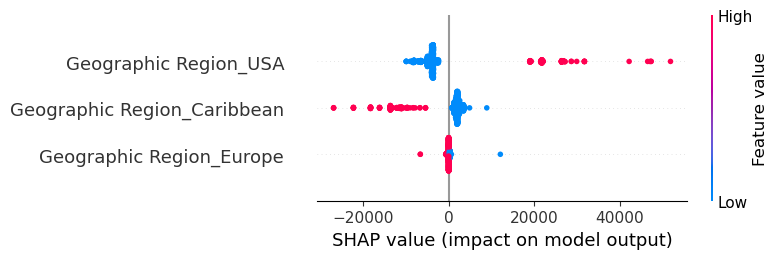

In [32]:
# Filter the SHAP values for the 'Geographic Region' features
geographic_region_shap_values = shap_values[:, X_test.columns.str.startswith('Geographic Region')]

# Plot the summary plot for the 'Geographic Region' features
shap.summary_plot(geographic_region_shap_values.values, X_test.loc[:, X_test.columns.str.startswith('Geographic Region')])
